In [1]:
%matplotlib inline
# Import libraries needed
import pandas as pd
import numpy as np
import sklearn as sk
import matplotlib.pyplot as plt
from sklearn.cross_validation import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier

# Make results reproducible
np.random.seed(1234567890)
n_estimators=25

df = pd.read_csv('gapminder.csv')

variables = ['incomeperperson', 'alcconsumption', 'co2emissions', 'femaleemployrate', 
                'internetuserate', 'lifeexpectancy','polityscore','employrate','urbanrate']
                
# convert to numeric format
for variable in variables:
    df[variable] = pd.to_numeric(df[variable], errors='coerce')
    
# listwise deletion of missing values
subset = df[variables].dropna()

# Print the rows and columns of the data frame
print('Size of study data')
print(subset.shape)

Size of study data
(148, 9)


In [2]:
# Identify contries with a high level of income using the MAD (mean absolute deviation) method
subset['absolute_deviations'] = np.absolute(subset['incomeperperson'] - np.median(subset['incomeperperson']))
MAD = np.mean(subset['absolute_deviations'])

# This function converts the income per person absolute deviations to a high income flag
def high_income_flag(absolute_deviations):
    threshold = 3
    if (absolute_deviations/MAD) > threshold:
        return "Yes"
    else:
        return "No"

subset['High Income'] = subset['absolute_deviations'].apply(high_income_flag)
subset['High Income'] = subset['High Income'].astype('category')

In [3]:
# Remove the first variable from the list since the target is derived from it
variables.pop(0)

predictors = subset[variables]
targets = subset['High Income']

#Split into training and testing sets+
training_data, test_data, training_target, test_target  = train_test_split(predictors, targets, test_size=.4)

# Build the random forest classifier
classifier=RandomForestClassifier(n_estimators=n_estimators)
classifier=classifier.fit(training_data,training_target)

predictions=classifier.predict(test_data)

print('Classification Report')
print(sk.metrics.classification_report(test_target, predictions))

Classification Report
             precision    recall  f1-score   support

         No       0.98      0.98      0.98        53
        Yes       0.86      0.86      0.86         7

avg / total       0.97      0.97      0.97        60



In [4]:
print('Confusion Matrix')
print(sk.metrics.confusion_matrix(test_target, predictions))

Confusion Matrix
[[52  1]
 [ 1  6]]


In [5]:
print('Accuracy Score')
print(sk.metrics.accuracy_score(test_target, predictions))

Accuracy Score
0.966666666667


In [6]:
# Fit an Extra Trees model to the data
model = ExtraTreesClassifier()
model.fit(training_data,training_target)

# Display the relative importance of each attribute
feature_name = list(predictors.columns.values)
feature_importance = list(model.feature_importances_)
features = pd.DataFrame({'name':feature_name, 'importance':feature_importance}).sort_values(by='importance', ascending=False)
print(features.head(len(feature_name)))

   importance              name
4    0.402458    lifeexpectancy
3    0.206540   internetuserate
7    0.096377         urbanrate
1    0.074468      co2emissions
2    0.071094  femaleemployrate
0    0.067265    alcconsumption
6    0.046357        employrate
5    0.035441       polityscore


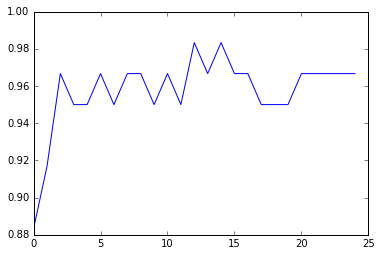

In [7]:
trees = range(n_estimators)
accuracy = np.zeros(n_estimators)

for idx in range(len(trees)):
    classifier=RandomForestClassifier(n_estimators=idx+1)
    classifier=classifier.fit(training_data,training_target)
    predictions=classifier.predict(test_data)
    accuracy[idx] = sk.metrics.accuracy_score(test_target, predictions)
    
plt.cla()
plt.plot(trees, accuracy)